# FBA QUANT AP HW6

Kim Soo Wan(hse07088@snu.ac.kr)
***

In [275]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

## Problem 1. Buffet’s Alpha 
(Source: BRK13F.csv)

The analyst wants to evaluate the performance of Berkshire Hathaway from Jan/1999 to Dec/2013. Determine whether the fund has generated alpha (i.e., excess returns that cannot be explained by exposure to some factors) using returns of the market, the size factor (SMB), the value factor (HML), the quality factor (QMJ), the low volatility factor (BAB), and the momentum factor (UMD).

1. Analyze the performance of BRK and determine whether the fund has generated alpha with the Fama-French 3 Factor Model (MKT, SMB, HML)
2. Analyze the performance of BRK and determine whether the fund has generated alpha with the Carhart 4 Factor Model (MKT, SMB, HML, UMD)
3. Analyze the performance of BRK and determine whether the fund has generated alpha with the 6 Factor Model (MKT, SMB, HML, QMJ, BAB, UMD)

- Hint:
    1. Calculate the excess returns for the market, size, and value factors by subtracting the risk-free rate of return from their monthly returns.
    2. Regress the BRK's excess returns against the excess returns of the market, size, and value factors using the Fama-French 3 Factor model:
    $$BRK\ excess\ return=\alpha+\beta_{MKT}\times market\ excess\ return+\beta_{SMB}\times size\ excess\ return+\beta_{HML}\times value\ excess\ returns+\epsilon\ (error\ term)$$
    3. Test the regression equation using various statistical methods.
    $$(1)Whether\ \alpha=0, (2)\epsilon\ is\ white\ noise, \left(3\right)explanatory\ power\ of\ regression\ model,\ etc.$$
    4. Compare this model to other models using evaluation metrics such as AIC, BIC, and so on.

In [276]:
data = pd.read_csv('data/BRK13F.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datadate  180 non-null    object 
 1   BRK.A     180 non-null    float64
 2   MKT       180 non-null    float64
 3   SMB       180 non-null    float64
 4   HML       180 non-null    float64
 5   RF        180 non-null    float64
 6   QMJ       180 non-null    float64
 7   BAB       180 non-null    float64
 8   UMD       180 non-null    float64
dtypes: float64(8), object(1)
memory usage: 12.8+ KB


In [277]:
data.head()

,datadate,BRK.A,MKT,SMB,HML,RF,QMJ,BAB,UMD
0,1/29/1999,2.01,3.63,-1.24,-3.61,0.364,-3.54,-3.87,2.34
1,2/26/1999,-1.53,-4.13,-3.85,2.15,0.379,-0.41,0.94,-0.40
2,3/31/1999,1.50,3.52,-3.85,-2.98,0.364,-2.50,-7.73,-2.51
3,4/30/1999,5.33,4.56,2.88,3.47,0.369,-4.54,-0.20,-9.13
4,5/28/1999,-2.07,-2.55,5.64,1.15,0.378,1.82,3.62,-2.98


In [278]:
data['datadate'] = pd.to_datetime(data['datadate'], format="%m/%d/%Y").dt.to_period(freq='M')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype    
---  ------    --------------  -----    
 0   datadate  180 non-null    period[M]
 1   BRK.A     180 non-null    float64  
 2   MKT       180 non-null    float64  
 3   SMB       180 non-null    float64  
 4   HML       180 non-null    float64  
 5   RF        180 non-null    float64  
 6   QMJ       180 non-null    float64  
 7   BAB       180 non-null    float64  
 8   UMD       180 non-null    float64  
dtypes: float64(8), period[M](1)
memory usage: 12.8 KB


,datadate,BRK.A,MKT,SMB,HML,RF,QMJ,BAB,UMD
0,1999-01,2.01,3.63,-1.24,-3.61,0.364,-3.54,-3.87,2.34
1,1999-02,-1.53,-4.13,-3.85,2.15,0.379,-0.41,0.94,-0.40
2,1999-03,1.50,3.52,-3.85,-2.98,0.364,-2.50,-7.73,-2.51
3,1999-04,5.33,4.56,2.88,3.47,0.369,-4.54,-0.20,-9.13
4,1999-05,-2.07,-2.55,5.64,1.15,0.378,1.82,3.62,-2.98


In [279]:
# Hint 1. 
data[['MKT','SMB','HML', 'QMJ', 'BAB', 'UMD']] = data[['MKT','SMB','HML', 'QMJ', 'BAB', 'UMD']].sub(data['RF'], axis=0) 
data.head()

,datadate,BRK.A,MKT,SMB,HML,RF,QMJ,BAB,UMD
0,1999-01,2.01,3.266,-1.604,-3.974,0.364,-3.904,-4.234,1.976
1,1999-02,-1.53,-4.509,-4.229,1.771,0.379,-0.789,0.561,-0.779
2,1999-03,1.50,3.156,-4.214,-3.344,0.364,-2.864,-8.094,-2.874
3,1999-04,5.33,4.191,2.511,3.101,0.369,-4.909,-0.569,-9.499
4,1999-05,-2.07,-2.928,5.262,0.772,0.378,1.442,3.242,-3.358


In [280]:
def mutli_factor_model(factors):
    factor_data = sm.add_constant(data[factors]) # Hint 2.
    model = sm.OLS(data['BRK.A'], factor_data).fit()
    print("factors : ", factors)
    print(model.summary())
    return model

**White test**
- In statistics, the White test is a statistical test that establishes whether the variance of the errors in a regression model is constant: that is for homoskedasticity
    - Null (H0): Homoscedasticity is present (residuals are equally scattered)
    - Alternative (HA): Heteroscedasticity is present (residuals are not equally scattered)
- ex) statsmodels.stats.diagnostic.het_white 

In [281]:
def is_errors_white_noise(model):
    errors=model.resid
    print("30-priod std of errors")
    plt.plot(errors.rolling(window=30).std().dropna())
    plt.show()
    white_test = het_white(errors, model.model.exog)
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
    print("Result of White's Test")
    print(dict(zip(labels, white_test)))

In [282]:
def analyze_pkt(factors):
    is_errors_white_noise(mutli_factor_model(factors))

1. MKT, SMB, HML

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


factors :  ['MKT', 'SMB', 'HML']
                            OLS Regression Results                            
Dep. Variable:                  BRK.A   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     95.52
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           9.85e-37
Time:                        02:29:49   Log-Likelihood:                -436.91
No. Observations:                 180   AIC:                             881.8
Df Residuals:                     176   BIC:                             894.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.54

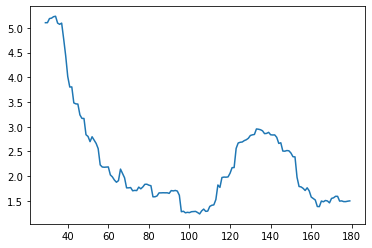

Result of White's Test
{'Test Statistic': 43.46645496420261, 'Test Statistic p-value': 1.7695959577336699e-06, 'F-Statistic': 6.013416248713469, 'F-Test p-value': 2.637039890736112e-07}


In [283]:
factors=['MKT', 'SMB', 'HML']
analyze_pkt(factors)

- Analysis

    0. F-statistics = 96.13 and Prob (F-statistic):	6.98e-37. Thus, this model is statistically statistically significant.
    1. $Whether~\alpha=0?$ regression result for $\alpha$ was 0.3625, but the result of t-test implies that the null hyphothesis of $H_o:\alpha=0$ can be rejected even at confidence level 99%. It can be said The fund is generating alpha and BRK.A is making profits.
    2. Unfortunately, the errors are not likely white noise since its 30-period std varies over whole period. White's test produces consistent results of null hypothesis residuals are equally scattered can be rejected under 95% confidence level.
    3. For each factor, by the t-test, null hyphothesis of BRK.A is irrelevant(coefficient is 0) with the factor was able to be rejectend at confidence level 99%.
        
        Adj. R-squared was 0.615 reprsenting 3 factors explain BRK.A's variance about 61.5%.
    4. AIC : ?

2. MKT, SMB, HML, UMD

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


factors :  ['MKT', 'SMB', 'HML', 'UMD']
                            OLS Regression Results                            
Dep. Variable:                  BRK.A   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     77.79
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           8.50e-38
Time:                        02:30:02   Log-Likelihood:                -431.92
No. Observations:                 180   AIC:                             873.8
Df Residuals:                     175   BIC:                             889.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

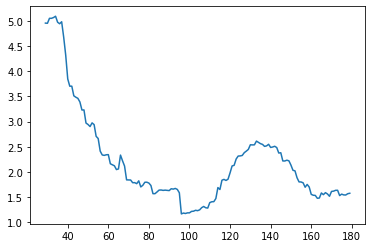

Result of White's Test
{'Test Statistic': 61.402840338914295, 'Test Statistic p-value': 6.648357367291069e-08, 'F-Statistic': 6.101970187429617, 'F-Test p-value': 1.1503065718090872e-09}


In [284]:
factors=['MKT', 'SMB', 'HML', 'UMD']
analyze_pkt(factors)

- Analysis

    0. Prob (F-statistic):	8.50e-38. Thus, this model is statistically statistically significant.
    1. $Whether~\alpha=0?$ regression result for $\alpha$ was 0.5829. The result of t-test implies that the null hyphothesis of $H_o:\alpha=0$ can be barely rejected under confidence level 95%. It may be said The fund is generating alpha and BRK.A is making profits.
    2. Unfortunately, the errors still seems are not white noise since its 30-period std varies over whole period. White's test produces consistent results of null hypothesis residuals are equally scattered can be rejected at 95% confidence level.
    3. For each factor, the null hypothesis of BRK.A being irrelevant (coefficient = 0) can be rejected with a 99% confidence level, except for UMD, which could only be rejected at a 95% confidence level using the t-test
        
        Adj. R-squared was 0.632 reprsenting 3 factors explain BRK.A's variance about 63.2%. *Not much improvements from 3 factor model.*
    4. AIC : ?

3. MKT, SMB, HML, QMJ, BAB, UMD

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


factors :  ['MKT', 'SMB', 'HML', 'QMJ', 'BAB', 'UMD']
                            OLS Regression Results                            
Dep. Variable:                  BRK.A   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     54.42
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           2.47e-37
Time:                        02:30:30   Log-Likelihood:                -428.45
No. Observations:                 180   AIC:                             870.9
Df Residuals:                     173   BIC:                             893.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

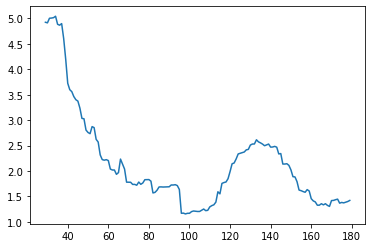

Result of White's Test
{'Test Statistic': 87.7739449935123, 'Test Statistic p-value': 2.3808033479279132e-08, 'F-Statistic': 5.357865533879747, 'F-Test p-value': 6.962657536718385e-12}


In [286]:
factors=['MKT', 'SMB', 'HML', 'QMJ', 'BAB','UMD']
analyze_pkt(factors)

- Analysis

    0. Prob (F-statistic):	2.47e-37. Thus, this model is statistically statistically significant.
    1. $Whether~\alpha=0?$ regression result for $\alpha$ was 0.4833. The result of t-test implies that the null hyphothesis of $H_o:\alpha=0$ can be rejected under confidence level 95%. It may be said the fund is generating alpha and BRK.A is making profits.
    2. Unfortunately, it is not likely the errors are white noise since its 30-period std varies over whole period. White's test produces consistent results of null hypothesis residuals are equally scattered can be rejected at 95% confidence level.
    3. For BAB, its p-value is cremendously high and the null hypothesis of the factor and BRK.A are irrelevent can't be rejected even at very low level of confidence.
    
        For the Others, the null hypothesis can be rejected with a 95% confidence level.
        
        Adj. R-squared was 0.632 reprsenting 3 factors explain BRK.A's variance about 63.2%. *Not much improvements from 3 factor model.*
    4. AIC : ?